<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/fitness_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U kaleido

In [2]:
!pip install -q japanize-matplotlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [15]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### 地理マスタ

In [6]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [7]:
df_navitime_org = pd.read_csv(os.path.join(DIR_NAME, 'navitime_master.csv'))[['名称', 'データ元', '緯度', '経度']]
print(df_navitime_org.shape)

(7854, 4)


In [8]:
df_sports_class = df_navitime_org[
    df_navitime_org['データ元'].isin(['フィットネス', 'スポーツ教室', 'ダンス教室', 'ゴルフ練習場', 'テニス教室'])
].rename(columns={'データ元': '施設分類'}).reset_index(drop=True)
print(df_sports_class.shape)

(2551, 4)


In [9]:
sports_types = list(df_sports_class['施設分類'].unique())

In [10]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.02) &    # 約2km以内
            ((_df_cat['経度'] - lon).abs() < 0.02)      # 約2km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [11]:
%%time
radius = 0.5    # 0.5km以内の施設の数
for sports in sports_types:
    df_geo_master[f'{sports}(数)'] = get_value_of_nearest_facility(df_geo_master, df_sports_class, sports, 'count', radius)
    print(sports)

ダンス教室
フィットネス
テニス教室
ゴルフ練習場
スポーツ教室
CPU times: user 38.1 s, sys: 553 ms, total: 38.7 s
Wall time: 44.7 s


In [17]:
feature_list = [col for col in df_geo_master.columns if col.endswith(')')]
print(feature_list)

['ダンス教室(数)', 'フィットネス(数)', 'テニス教室(数)', 'ゴルフ練習場(数)', 'スポーツ教室(数)']


ダンス教室(数)


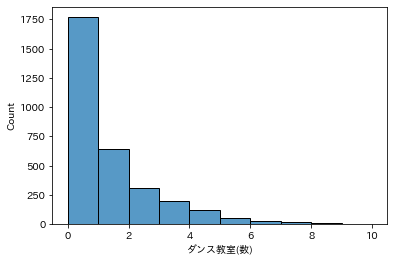

フィットネス(数)


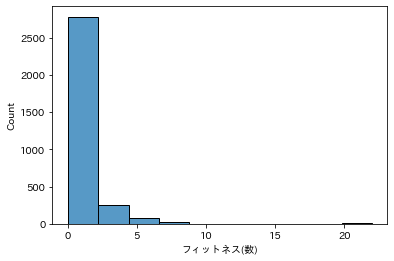

テニス教室(数)


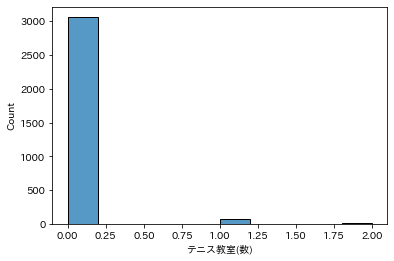

ゴルフ練習場(数)


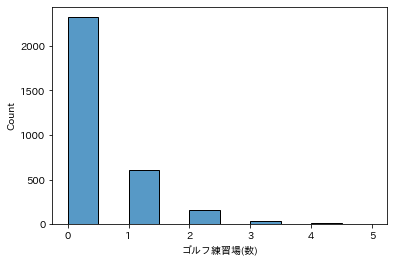

スポーツ教室(数)


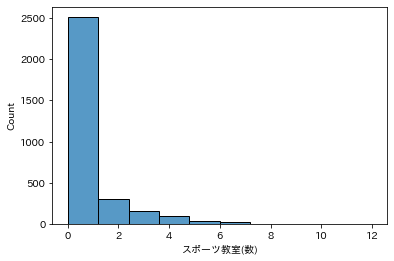

In [16]:
for feature in feature_list:
    print(feature)
    sns.histplot(df_geo_master[feature], bins=10)
    plt.show()

In [20]:
df_geo_master[['town_id'] + feature_list].to_csv(os.path.join(DIR_NAME, 'fitness_score.csv'), encoding='utf-8_sig', index=False)